In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from tqdm import tqdm
import numpy
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets




In [36]:
class KPCA:
    def __init__(self, kernel):
        self.kernel = kernel
        self.X = None
        self.A = None
        self.MV= None
        
    def getNormalise(self, data):
        len= data.shape[0]
        data_1 = numpy.ones((len, len)) / len
        GramMatrix= self.kernel.GramMatrix(data)
        self.MV = numpy.mean(GramMatrix, axis=1) - numpy.mean(GramMatrix)
        return numpy.dot(numpy.dot(numpy.eye(len) - data_1, GramMatrix), numpy.eye(len) - data_1)
    
    def fit(self, data):
        print("Finding !!! ")
        length = data.shape[0]
        self.X = data
        GM = self.getNormalise(data)       
        eig_values, eig_vectors = linalg.eigh(GM)       
        i = range(length)[::-1]
        eig_values = eig_values[i]
        eig_vectors = eig_vectors[:, i]        
        i = eig_values > 0
        eig_values = eig_values[i]
        eig_vectors = eig_vectors[:, i]
        self.A = eig_vectors
        for a, b in enumerate(eig_values):
            self.A[:, a] /= numpy.sqrt(b)
            
    def predict(self, X, cluster=None):
        assert cluster is None or (cluster > 0 and cluster <= self.A.shape[1])
        if cluster is None:
            cluster = self.A.shape[1]

        GM = self.kernel.GramMatrix(X, self.X)
        K = GM - numpy.mean(GM, axis=1)[:, numpy.newaxis] - self.MV
        return numpy.dot(GM, self.A[:, :cluster])
            
        

In [37]:
class Kernel:
    def __init__(self):
        self.name = None

    def calc(self, x, y):
        raise NotImplementedError("Not Done")

    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        n = X.shape[0]
        m = Y.shape[0]
        K = numpy.zeros((n, m))

        for i in tqdm(range(n)):
            for j in range(m):
                K[i, j] = self.calc(X[i, :], Y[j, :])
        return K

In [38]:
class PolynomialKernel(Kernel):
    def __init__(self, degree):
        self.degree = degree
        self.name = 'polynomial_%d' % degree
        
    def calc(self, x, y):
        return (1 + numpy.dot(x, y)) ** self.degree
    
    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        return numpy.dot(X, Y.T) **self.degree

class LinearKernel(Kernel):
    def __init__(self):
        self.name = 'linear'

    def calc(self, x, y):
        return numpy.dot(x, y)

    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        return numpy.dot(X, Y.T)

In [39]:
class GaussianKernel(Kernel):
    def __init__(self, sigma):
        self.sigma = sigma
        self.name = 'gaussian_%.5f' % sigma

    def calc(self, x, y):
        return numpy.exp(-numpy.linalg.norm(x - y) ** 2 / (2 * self.sigma ** 2))

    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        n = X.shape[0]
        m = Y.shape[0]
        K = numpy.zeros((n, m))

        for i in tqdm(range(m)):
            K[:, i] = numpy.linalg.norm(X - Y[i, :], axis=1) ** 2
        K /= 2 * self.sigma ** 2
        return numpy.exp(-K)

In [40]:
class LaplacianKernel():
    def __init__(self, sigma):
        self.sigma = sigma
        self.name = 'gaussian_%.2f' % sigma

    def calc(self, x, y):
            val=numpy.exp(-numpy.linalg.norm(x - y) *self.sigma)
            print("Value is"+val)
            return val

    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        n = X.shape[0]
        m = Y.shape[0]
        K = numpy.zeros((n, m))

        for i in tqdm(range(m)):
            K[:, i] = numpy.linalg.norm(X - Y[i, :], axis=1)* self.sigma
       
        return numpy.exp(-K)

In [41]:
#First we will test from Standard PCA 
from sklearn.decomposition import PCA
from sklearn.datasets import make_circles
nb_samples = 1000
X, Y= make_circles(n_samples=nb_samples, noise=0.01)
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
Components = scikit_pca.fit_transform(X)



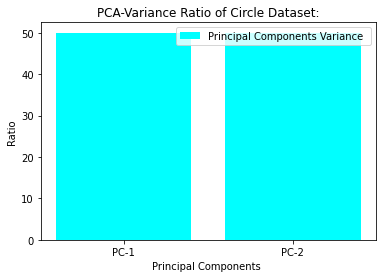

In [42]:
totV = np.var(Components, axis=0)
value_eigen = totV / np.sum(totV)
plt.bar([1,2],list(value_eigen*100),label='Principal Components Variance ',color='cyan')
plt.legend()
plt.xlabel('Principal Components ')
#----------------------
length=list(value_eigen*100)
prinComp=[]
for i in range(len(length)):
    length[i]=round(length[i],4)
    prinComp.append('PC-'+str(i+1))

#----------------------
plt.xticks([1,2],prinComp, fontsize=10)
plt.ylabel('Ratio')
plt.title('PCA-Variance Ratio of Circle Dataset:')
plt.show()

In [43]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
Components = scikit_pca.fit_transform(X)
axes = pd.DataFrame(data = Components
                 , columns = ['PC-1', 'PC-2'])

print(X_spca.shape)

(1000, 2)


Text(0, 0.5, 'Second Principal Component')

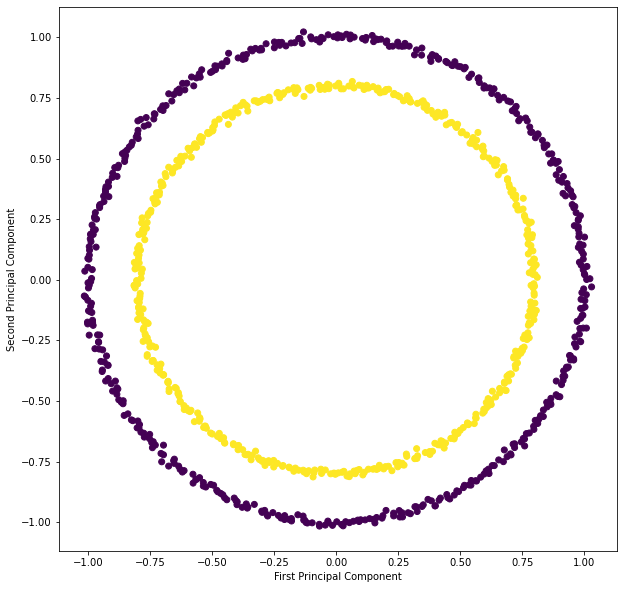

In [44]:
#plotting based on target values
plt.figure(figsize=(10,10))
plt.scatter(Components[:,0],Components[:,1],c=Y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [47]:
# splitting testing ab=nd training data
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(X_spca, Y, test_size=0.2, random_state=33)

# training the SVM classifier
clf=SVC()
clf.fit(x_train, y_train)

# predicting the results
pred = clf.predict(x_test)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('\nClasification report:\n', classification_report(y_test, pred))
print ('\nConfussion matrix:\n',confusion_matrix(y_test, pred))



Clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       107
           1       1.00      1.00      1.00        93

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confussion matrix:
 [[107   0]
 [  0  93]]


In [48]:
#Applying Kernel PCA 
#Guassian Kernel :
#umber of components =2 and Gamma=100
kpca = KPCA(GaussianKernel(100))
X_kpca=kpca.fit(X)
X_kpca1 = kpca.predict(X,1)
Components_kpca = kpca.predict(X,2)
axes = pd.DataFrame(data = Components_kpca
                 , columns = ['PC-1', 'PC-2'])
print(X_kpca1.shape)


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16952.64it/s]

Finding !!! 



100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 19608.71it/s]

(1000, 1)


Text(0, 0.5, 'Second Principal Component')

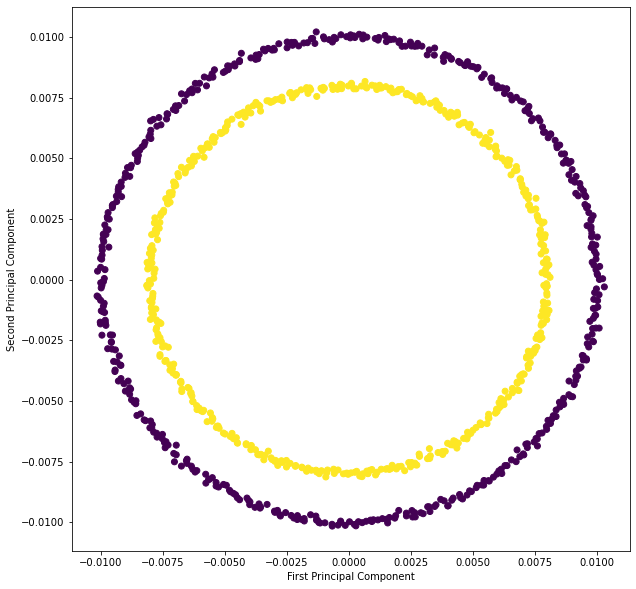

In [49]:
#plotting based on target values
plt.figure(figsize=(10,10))
plt.scatter(Components_kpca[:,0],Components_kpca[:,1],c=Y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [50]:
# splitting testing ab=nd training data
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(X_kpca1, Y, test_size=0.2, random_state=33)

# training the SVM classifier
clf=SVC()
clf.fit(x_train, y_train)

# predicting the results
pred = clf.predict(x_test)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('\nClasification report:\n', classification_report(y_test, pred))
print ('\nConfussion matrix:\n',confusion_matrix(y_test, pred))



Clasification report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60       107
           1       0.60      1.00      0.75        93

    accuracy                           0.69       200
   macro avg       0.80      0.71      0.68       200
weighted avg       0.82      0.69      0.67       200


Confussion matrix:
 [[46 61]
 [ 0 93]]


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 18852.50it/s]

Finding !!! 



100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 20155.62it/s]

(1000, 1)


Text(0, 0.5, 'Second Principal Component')

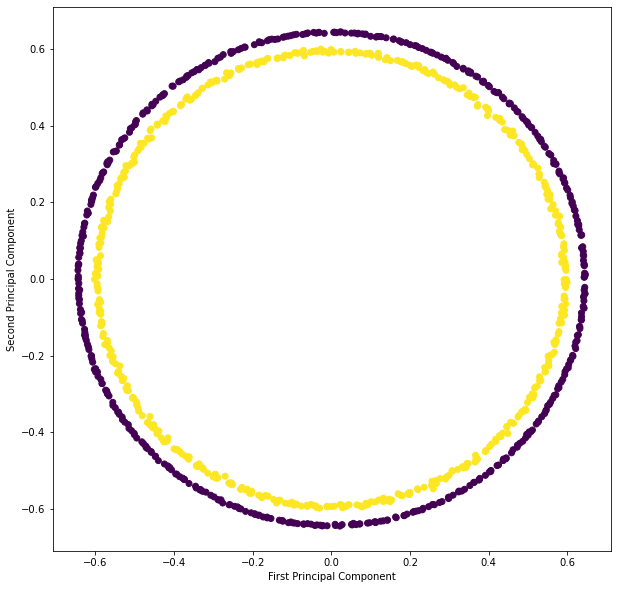

In [51]:
#Applying Kernel PCA 
#Guassian Kernel :
#umber of components =2 and Gamma=100
kpca = KPCA(GaussianKernel(1))
X_kpca=kpca.fit(X)
X_kpca1 = kpca.predict(X,1)
Components_kpca = kpca.predict(X,2)
axes = pd.DataFrame(data = Components_kpca
                 , columns = ['PC-1', 'PC-2'])
print(X_kpca1.shape)
#plotting based on target values
plt.figure(figsize=(10,10))
plt.scatter(Components_kpca[:,0],Components_kpca[:,1],c=Y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 17228.39it/s]

Finding !!! 



100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 20014.05it/s]


(1000, 1)


Text(0, 0.5, 'Second Principal Component')

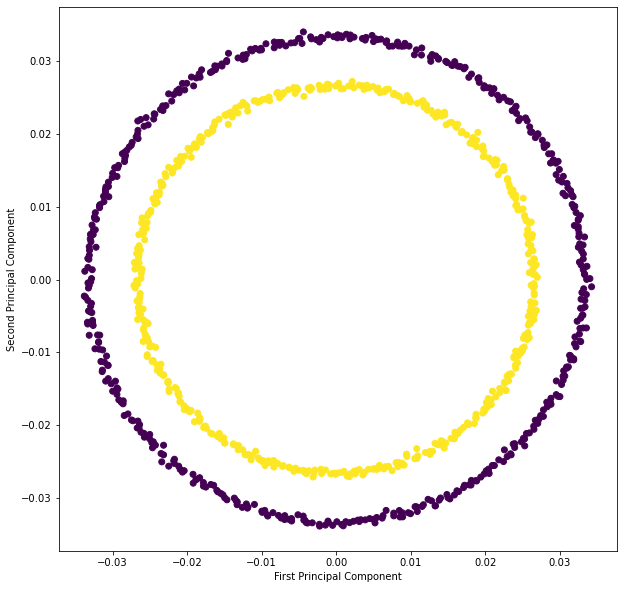

In [52]:
#Applying Kernel PCA 
#Guassian Kernel :
#umber of components =2 and Gamma=100
kpca = KPCA(GaussianKernel(30))
X_kpca=kpca.fit(X)
X_kpca1 = kpca.predict(X,1)
Components_kpca = kpca.predict(X,2)
axes = pd.DataFrame(data = Components_kpca
                 , columns = ['PC-1', 'PC-2'])
print(X_kpca1.shape)
#plotting based on target values
plt.figure(figsize=(10,10))
plt.scatter(Components_kpca[:,0],Components_kpca[:,1],c=Y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [53]:
# splitting testing ab=nd training data
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(X_kpca1, Y, test_size=0.2, random_state=33)

# training the SVM classifier
clf=SVC()
clf.fit(x_train, y_train)

# predicting the results
pred = clf.predict(x_test)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('\nClasification report:\n', classification_report(y_test, pred))
print ('\nConfussion matrix:\n',confusion_matrix(y_test, pred))


Clasification report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60       107
           1       0.60      1.00      0.75        93

    accuracy                           0.69       200
   macro avg       0.80      0.71      0.68       200
weighted avg       0.82      0.69      0.67       200


Confussion matrix:
 [[46 61]
 [ 0 93]]


Finding !!! 
(1000, 1)


Text(0, 0.5, 'Second Principal Component')

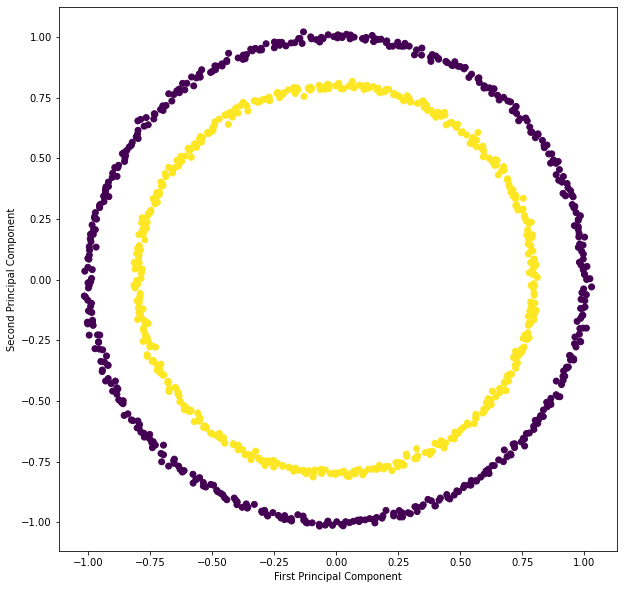

In [56]:
#Applying Kernel PCA 
#Guassian Kernel :
#umber of components =2 and Linear
kpca = KPCA(LinearKernel())
X_kpca=kpca.fit(X)
X_kpca1 = kpca.predict(X,1)
Components_kpca = kpca.predict(X,2)
axes = pd.DataFrame(data = Components_kpca
                 , columns = ['PC-1', 'PC-2'])
print(X_kpca1.shape)
#plotting based on target values
plt.figure(figsize=(10,10))
plt.scatter(Components_kpca[:,0],Components_kpca[:,1],c=Y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [57]:
# splitting testing ab=nd training data
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(X_kpca1, Y, test_size=0.2, random_state=33)

# training the SVM classifier
clf=SVC()
clf.fit(x_train, y_train)

# predicting the results
pred = clf.predict(x_test)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('\nClasification report:\n', classification_report(y_test, pred))
print ('\nConfussion matrix:\n',confusion_matrix(y_test, pred))


Clasification report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60       107
           1       0.60      1.00      0.75        93

    accuracy                           0.69       200
   macro avg       0.80      0.71      0.68       200
weighted avg       0.82      0.69      0.67       200


Confussion matrix:
 [[46 61]
 [ 0 93]]


Finding !!! 
(1000, 1)


Text(0, 0.5, 'Second Principal Component')

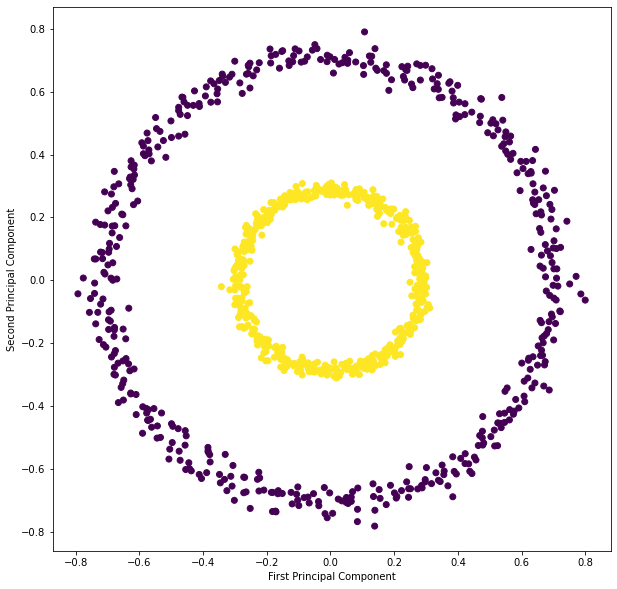

In [58]:
#Applying Kernel PCA 
#Guassian Kernel :
#umber of components =2 and Gamma=100
kpca = KPCA(PolynomialKernel(4))
X_kpca=kpca.fit(X)
X_kpca1 = kpca.predict(X,1)
Components_kpca = kpca.predict(X,2)
axes = pd.DataFrame(data = Components_kpca
                 , columns = ['PC-1', 'PC-2'])
print(X_kpca1.shape)
#plotting based on target values
plt.figure(figsize=(10,10))
plt.scatter(Components_kpca[:,0],Components_kpca[:,1],c=Y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [59]:
# splitting testing ab=nd training data
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(X_kpca1, Y, test_size=0.2, random_state=33)

# training the SVM classifier
clf=SVC()
clf.fit(x_train, y_train)

# predicting the results
pred = clf.predict(x_test)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('\nClasification report:\n', classification_report(y_test, pred))
print ('\nConfussion matrix:\n',confusion_matrix(y_test, pred))


Clasification report:
               precision    recall  f1-score   support

           0       1.00      0.63      0.77       107
           1       0.70      1.00      0.82        93

    accuracy                           0.80       200
   macro avg       0.85      0.81      0.80       200
weighted avg       0.86      0.80      0.79       200


Confussion matrix:
 [[67 40]
 [ 0 93]]


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16528.82it/s]

Finding !!! 



100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16666.75it/s]

(1000, 1)


Text(0, 0.5, 'Second Principal Component')

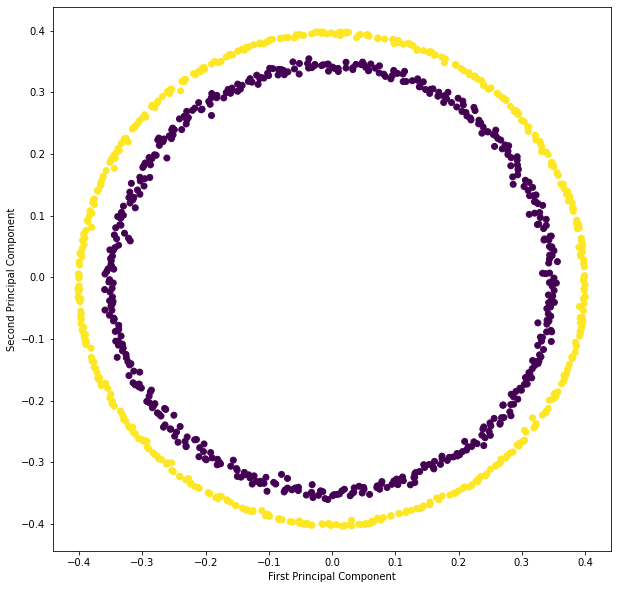

In [60]:
#Applying Kernel PCA 
#Guassian Kernel :
#umber of components =2 and Gamma=100
kpca = KPCA(LaplacianKernel(4))
X_kpca=kpca.fit(X)
X_kpca1 = kpca.predict(X,1)
Components_kpca = kpca.predict(X,2)
axes = pd.DataFrame(data = Components_kpca
                 , columns = ['PC-1', 'PC-2'])
print(X_kpca1.shape)
#plotting based on target values
plt.figure(figsize=(10,10))
plt.scatter(Components_kpca[:,0],Components_kpca[:,1],c=Y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [61]:
# splitting testing ab=nd training data
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(X_kpca1, Y, test_size=0.2, random_state=33)

# training the SVM classifier
clf=SVC()
clf.fit(x_train, y_train)

# predicting the results
pred = clf.predict(x_test)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('\nClasification report:\n', classification_report(y_test, pred))
print ('\nConfussion matrix:\n',confusion_matrix(y_test, pred))


Clasification report:
               precision    recall  f1-score   support

           0       0.62      0.84      0.72       107
           1       0.70      0.42      0.52        93

    accuracy                           0.65       200
   macro avg       0.66      0.63      0.62       200
weighted avg       0.66      0.65      0.63       200


Confussion matrix:
 [[90 17]
 [54 39]]
